## Regression of a function with a neural network in 1D


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Generate synthetic data
x = torch.linspace(0, 5, 100)
x.requires_grad = True
x = x.unsqueeze(-1)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        # self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        # x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the loss function
MSELoss = lambda x, y: torch.mean(torch.square(x - y))

def train_net(net, x, get_dydx, get_y_lhs, get_y_rhs, criterion, verbose = False):
    optimizer = optim.LBFGS(net.parameters(), lr=0.01)
    for i in range(100):
        def closure():
            optimizer.zero_grad()
            # outputs = net(x)
            y = get_y_rhs(x, net)
            dydx = get_dydx(x, net, get_y_lhs)
            loss = criterion(y, dydx) 
            loss.backward()
            return loss

        loss=optimizer.step(closure)

        if(verbose):
            if(i%10==0):
                print(i," ",loss.item())

    # Print the final loss
      
def plot_net(net, x, get_y, ax = None):
    # Plot the results
    with torch.no_grad():
        outputs = get_y(x, net)

    if ax is None:
        fig, plot_ax = plt.subplots()
    else:
        plot_ax = ax

    plot_ax.plot(x.detach().numpy(),  outputs.detach().numpy(), label='Neural Network Prediction', color='red')
    plot_ax.set_xlabel('x')
    plot_ax.set_ylabel('y')
    plot_ax.legend()

    if ax is None:
        plt.show()

### Exercise 2:
Modify the code to solve the differential equation
$$
\frac{dy}{dx} = -y(x);\; y(0) = 1
$$
using
 a) finite difference method to calculate derivatives.

Add boundary conditions as another loss function.


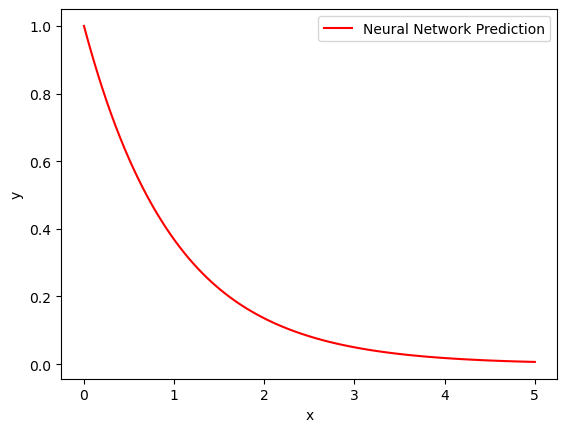

In [69]:

def get_dydx(x, net, getout):
    h = 0.001
    dydx = (getout(x+h, net) - getout(x-h, net)) /(2*h)
    return -dydx


def get_y(x, net):
    return net(x)


net = Net()

MSELoss_w_bound = lambda x, y: MSELoss(x, y) + torch.square(net(torch.tensor([0.])) - torch.tensor( [1.]))/10.


train_net(net, x, get_dydx, get_y, get_y, MSELoss_w_bound)

plot_net(net, x, get_y)

 b) automatic differentiation to calculate derivatives. 

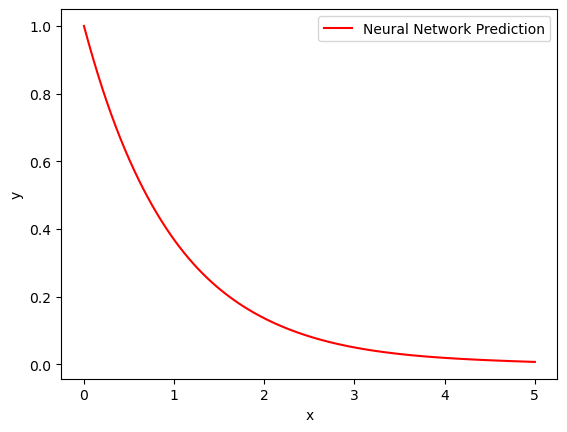

In [70]:
def get_dydx_auto(x, net, get_y_lhs):
    y = get_y_lhs(x, net)
    dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    
    return -dydx

net = Net()

train_net(net, x, get_dydx_auto, get_y, get_y, MSELoss_w_bound)

plot_net(net, x, get_y)


### Exercise 3:
Solve the same differential equation using
$$
y = 1+x\,\mathrm{Net}(x)
$$
This way we do not need to add another loss function.


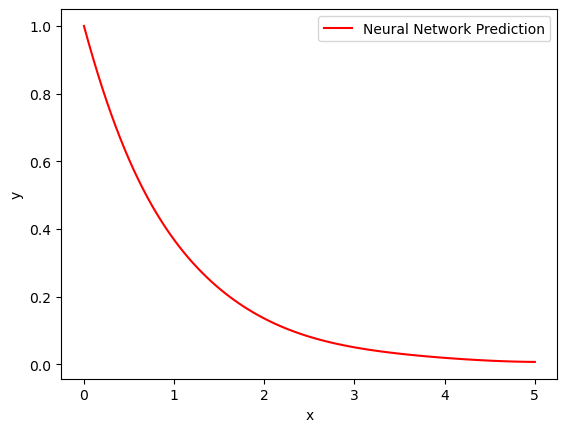

In [71]:
def get_y_smart(x, net):
    return 1 + x * net(x)

net = Net()
train_net(net, x, get_dydx, get_y_smart, get_y_smart, MSELoss)

plot_net(net, x, get_y_smart)


### Exercise 4:
Solve the differential equation
$$
\frac{dy}{dx} = -y\,(x-1);\; y(0) = 1
$$
Run the code twice to see whether the results are the same. The results for two successive runs may not be the same. Explain why this is the case.

In [79]:
def get_y_rhs(x, net):
    return net(x-1)

def get_y_lhs(x, net):
    return net(x)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(5):
    net = Net()

    MSELoss_w_bound = lambda x, y: MSELoss(x, y) + torch.square(net(torch.tensor([0.])) - torch.tensor( [1.]))/10.

    train_net(net, x, get_dydx, get_y_lhs, get_y_rhs, MSELoss_w_bound)
    plot_net(net, x, get_y_lhs, ax=ax)

plt.show()